Sequencing technology has change a lot in the past 5 years. There has been a substantial increase in the number of reads produced by a single sequencing run, and an increase in the number of bases that can be sequenced. During the pre-pre-alignment workflow I estimate library size and calculate the average read length. I would like to remove overtly low quality samples that have a small number of reads and reads that are very short. 

Here I look at these distributions and I can see that most samples have more than 1 million reads. There is a small number of samples (~2k) that have fewer than 100,000 reads. I have decided to flag these samples as having a low library size. If I further summarize to SRX, there are ~400 experiments with fewer than 100k total reads.

In addition I looked at the average read length and found that most samples either have a read length of 50 or 75-100 bp. There are ~700 samples that have an average read length less than 30. I have flagged these samples as having a low read length. Note the alignment pipeline throws out individual reads that are ≤20 bp.

**Output**
* This notebook generates distribution plots of library size and average read length.
* This notebook outputs a table with flags `../../output/libsize_downstream_analysis.pkl`
    * `libsize` The total number of reads (for PE only R1).
    * `len` Average read length (for PE only R1).
    * `flag_low_libsize` Flag is True when library size < 100,000 reads.
    * `flag_short_read_len` Flag is True when read length < 30 bp.

In [1]:
# %load ../config/defaults.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')
sns.set_style('white')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-09-26 
Git hash: 3a65830db8822599370f17669b4b3d2b5ea20bd5


In [2]:
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra2']
remap = db['remap']


In [3]:
# Query DB and get read information.

## Quick count for sanity
num_runs = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'},
            ]
        }
    },
    {'$count': 'cnt'}
]))[0]['cnt']

In [4]:
# Make read information dataframes

## Single End
dfSE = pd.DataFrame(list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'},
                {'runs.pre_aln_flags': 'SE'},
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'libsize': {
                '$cond': [
                    {'$in': ['keep_R2', '$runs.pre_aln_flags']}, 
                    '$runs.libsize.R2',
                    '$runs.libsize.R1'
                ]
            },
            'len': {
                '$cond': [
                    {'$in': ['keep_R2', '$runs.pre_aln_flags']}, 
                    '$runs.avgReadLen.R2',
                    '$runs.avgReadLen.R1'
                ]
            },
            'hisat_num_reads': '$runs.pre_aln_workflow.hisat2.num_reads',
        }
    },
])))

## Pair End 
dfPE = pd.DataFrame(list(remap.aggregate([ {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'},
                {'runs.pre_aln_flags': 'PE'},
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'libsize_R1': '$runs.libsize.R1',
            'libsize_R2': '$runs.libsize.R2',
            'len_R1': '$runs.avgReadLen.R1',
            'len_R2': '$runs.avgReadLen.R2',
        }
    },
])))

## Make sure read 1 equals read 2. The pipeline should drop 
## unpaired reads so they should be the same
assert (dfPE.libsize_R1 == dfPE.libsize_R2).all()

## only keep R1 for easier matching with SE data.
dfPE.drop('libsize_R2', axis=1, inplace=True)
dfPE.drop('len_R2', axis=1, inplace=True)
dfPE.rename(columns={'libsize_R1': 'libsize', 'len_R1': 'len'}, inplace=True)

# concat SE and PE
df = pd.concat([dfSE, dfPE])
df.set_index(['srx', 'srr'], inplace=True)

# Test that we have all of the completed samples.
assert num_runs == df.shape[0]

# Library Size

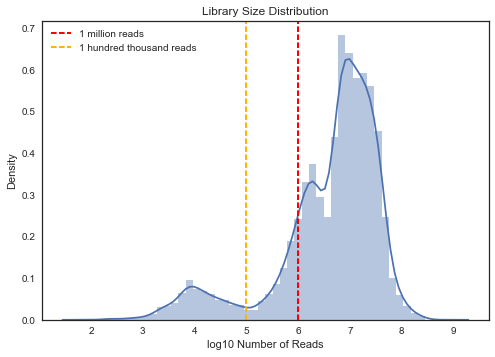

In [5]:
# plot distribution of library size
ax = sns.distplot(np.log10(df.libsize))
ax.axvline(np.log10(1e6), ls='--', lw=2, color='r', label='1 million reads')
ax.axvline(np.log10(1e5), ls='--', lw=2, color=sns.xkcd_rgb['amber'], label='1 hundred thousand reads')
ax.legend()
ax.set_xlabel('log10 Number of Reads')
ax.set_ylabel('Density')
ax.set_title('Library Size Distribution');

In [6]:
# Add flags for low library size
df['flag_low_libsize'] = False
df.loc[df.libsize < 1e5, 'flag_low_libsize'] = True

In [12]:
# How many samples are filtered with this flag?
print(
    'There were {:,} runs that had less than 100,000 reads.'.format(df.flag_low_libsize.sum())
)

There were 2,102 runs that had less than 100,000 reads.


In [24]:
# What is the smallest libsize?
print(
    'Sample {} had the smallest library size ({} reads).'.format(df.libsize.argmin()[1], df.libsize.min())
)

Sample SRR1992316 had the smallest library size (73 reads).


# Read Length

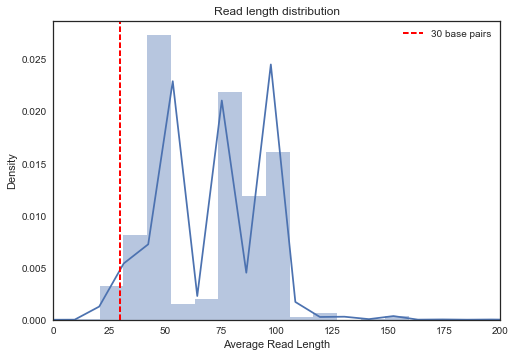

In [20]:
# plot distribution of read lengths
ax = sns.distplot(df.len, bins=100)
ax.set_xlabel('Average Read Length')
ax.set_ylabel('Density')
ax.set_xlim(0, 200)
ax.set_title('Read length distribution');
ax.axvline(30, ls='--', lw=2, color='r', label='30 base pairs')
ax.legend();

In [9]:
# make flags for short reads
df['flag_short_read_len'] = False
df.loc[df.len < 30, 'flag_short_read_len'] = True

In [21]:
# How many samples do we lose with short reads
print(
    'There were {:,} runs with average read lengths less than 30bp.'.format(
        df.flag_short_read_len.sum())
)

There were 697 runs with average read lengths less than 30bp.


In [28]:
# What is the shortest avg read length
print(
    'Sample {} had the smallest average read length (~{:.2f} bp).'.format(
        df.len.argmin()[1],
        df.len.min()
    )
)

Sample ERR297221 had the smallest average read length (~10.02 bp).


# Create table

In [45]:
# prep dataframe and export to pickle
df = df[['libsize',  'len', 'flag_low_libsize', 'flag_short_read_len']].copy()
df.to_pickle('../../output/libsize_downstream_analysis.pkl')

df.head()

,,libsize,len,flag_low_libsize,flag_short_read_len
srx,srr,,,,
SRX2556775,SRR5251041,2182591,151.0,False,False
SRX2556774,SRR5251040,784813,151.0,False,False
SRX2556773,SRR5251039,2864116,151.0,False,False
SRX2556772,SRR5251038,2565088,151.0,False,False
SRX2556771,SRR5251037,2253895,151.0,False,False


# Combine library sizes to SRX level

In [37]:
# Summarize to srx level
srx = df.libsize.groupby(level=0).sum().to_frame()

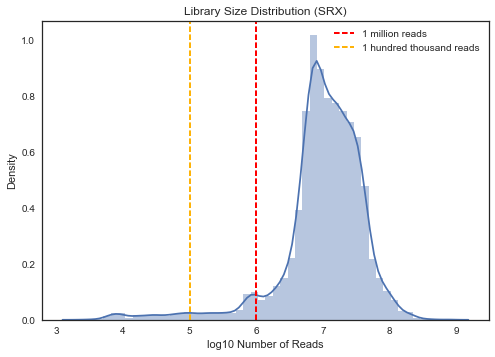

In [41]:
# Plot distribution at SRX level
ax = sns.distplot(np.log10(srx.libsize))
ax.axvline(np.log10(1e6), ls='--', lw=2, color='r', label='1 million reads')
ax.axvline(np.log10(1e5), ls='--', lw=2, color=sns.xkcd_rgb['amber'], label='1 hundred thousand reads')
ax.legend()
ax.set_xlabel('log10 Number of Reads')
ax.set_ylabel('Density')
ax.set_title('Library Size Distribution (SRX)');

In [44]:
# How many SRX are below 100k cutoff?
print(
    'There are {:,} SRX that have less than 100,000 total reads.'.format(
        (srx.libsize < 1e5).sum()
    )
)

There are 369 SRX that have less than 100,000 total reads.
